In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from PIL import Image
import pandas as pd
from nltk.corpus import wordnet

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
trump_tweet=pd.read_csv("trump_tweet.csv")
harris_tweet=pd.read_csv("harris_tweet.csv")

In [5]:
stopWords = set(STOPWORDS)
stopWords.update (["donald","trump","kamala","harris","would", "election", "could", "also", "president","vote", "voters", "house", "run", "two","way","go", "point", "take", "say","thank","will","going","nan"]) # for twitter

In [6]:
#모든 단어를 소문자로 변경
def tokenizing(document):
  token = []
  for sentence in document:
    clean_words=[]
    sentence = re.sub('[^a-zA-Z-]+',' ',sentence)

    for word in word_tokenize(sentence):
        if len(word)>2 and word.lower() not in stopWords:
            word = word.lower()
            clean_words.append(word)
    token.append(clean_words)
  return token

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None  # 품사가 명확하지 않으면 None 반환

lemmatizer = WordNetLemmatizer()

# 표제어화 함수 (모든 품사 지정)
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for token_list in tokens:
        tagged_tokens = nltk.pos_tag(token_list)  # 품사 태깅
        lemmatized_list = []
        for word, tag in tagged_tokens:
            wordnet_pos = get_wordnet_pos(tag)  # 품사를 변환
            if wordnet_pos:  # 품사가 있으면 표제어화
                lemmatized_list.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
            else:  # 없으면 기본 표제어화
                lemmatized_list.append(lemmatizer.lemmatize(word))
        lemmatized_tokens.append(lemmatized_list)
    return lemmatized_tokens

#다시 문장으로 생성
def make_sent_corpus(lemmatized_token):
  sent_corpus = [*map(lambda x: ' '.join(x) , lemmatized_token)]
  return sent_corpus

In [7]:
tt_text=[]
ht_text=[]
tt_text.append(' '.join(trump_tweet['text']))
ht_text.append(' '.join([str(text) for text in harris_tweet['text']]))

tt_text=tokenizing(tt_text)
ht_text=tokenizing(ht_text)

tt_text=lemmatize_tokens(tt_text)
ht_text=lemmatize_tokens(ht_text)

tt_text=make_sent_corpus(tt_text)
ht_text=make_sent_corpus(ht_text)

CountVectorizer 워드클라우드

In [8]:
trump_text=[]
harris_text=[]

vector_tt = CountVectorizer()
vector_ht = CountVectorizer()

# 문장 단위의 코퍼스를 전체 문장으로 결합
trump_text.append(' '.join(tt_text))
harris_text.append(' '.join(ht_text))

# 문서가 1개 짜리인 단어 콜랙션 만들기
ttt=vector_tt.fit_transform(trump_text)
htt=vector_ht.fit_transform(harris_text)

tt=pd.DataFrame(ttt.toarray(), columns=vector_tt.get_feature_names_out()).T
ht=pd.DataFrame(htt.toarray(), columns=vector_ht.get_feature_names_out()).T

tt.rename(columns={0:'frequency'}, inplace=True)
ht.rename(columns={0:'frequency'}, inplace=True)

tt=tt.to_dict()
ht=ht.to_dict()

In [9]:
trump_mask = np.array(Image.open("trump.jpg"))
harris_mask = np.array(Image.open("harris.png"))

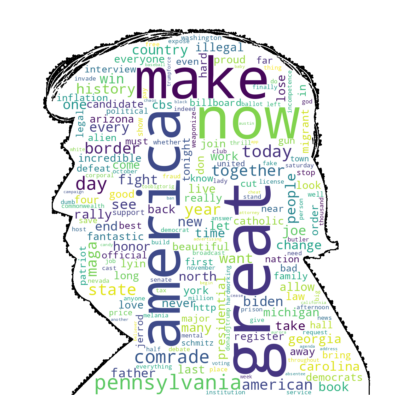

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords=set(STOPWORDS)

# 워드클라우드 생성
wordcloud = WordCloud(
    stopwords=stopwords,
    width=800,
    height=400,
    contour_width=2,
    background_color='white',
    mask=trump_mask
).generate_from_frequencies(tt['frequency'])

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

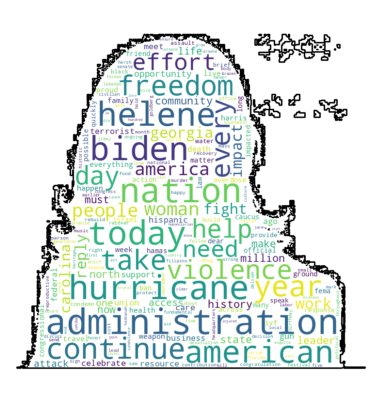

In [11]:
stopwords=set(STOPWORDS)

# 워드클라우드 생성
wordcloud = WordCloud(
    stopwords=stopwords,
    width=800,
    height=400,
    contour_width=2,
    background_color='white',
    mask=harris_mask
).generate_from_frequencies(ht['frequency'])

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

TF-IDF 워드클라우드

In [12]:
def TF_IDF(corpus):
    tfidfv = TfidfVectorizer(min_df=0.2).fit(corpus)
    return tfidfv

trump_tfidf=TF_IDF(tt_text)
harris_tfidf=TF_IDF(ht_text)

trump_TFIDF_matrix = trump_tfidf.transform(tt_text).toarray()
harris_TFIDF_matrix = harris_tfidf.transform(ht_text).toarray()

trump_word_index = {idx:word for (word,idx) in trump_tfidf.vocabulary_.items()}
harris_word_index = {idx:word for (word,idx) in harris_tfidf.vocabulary_.items()}


trump_TFIDF_sum = trump_TFIDF_matrix.sum(axis=0)
harris_TFIDF_sum = harris_TFIDF_matrix.sum(axis=0)

trump_TFIDF_frequencies = {trump_word_index[i]:trump_TFIDF_sum[i] for i in range(len(trump_tfidf.vocabulary_))}
harris_TFIDF_frequencies = {harris_word_index[i]:harris_TFIDF_sum[i] for i in range(len(harris_tfidf.vocabulary_))}

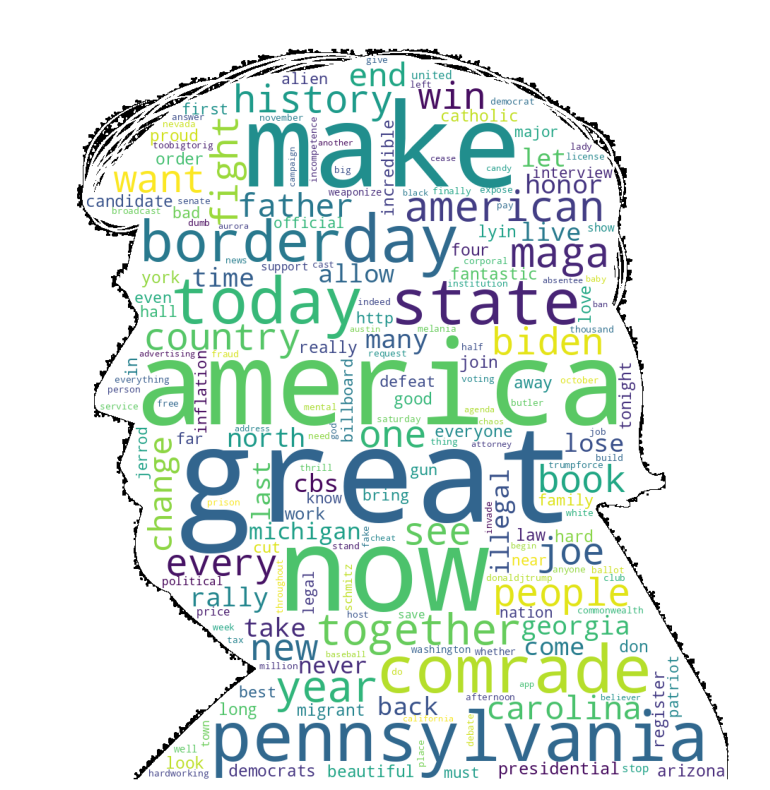

In [13]:
trump_wordcloud = WordCloud(relative_scaling = 0.2,
                     background_color='white',
                    width=800,
                    height=400,
                    mask=trump_mask,
                    contour_color='black',
                    contour_width=1
                     ).generate_from_frequencies(trump_TFIDF_frequencies)
plt.figure(figsize=(15,10))
plt.imshow(trump_wordcloud)
plt.axis("off")
plt.show()

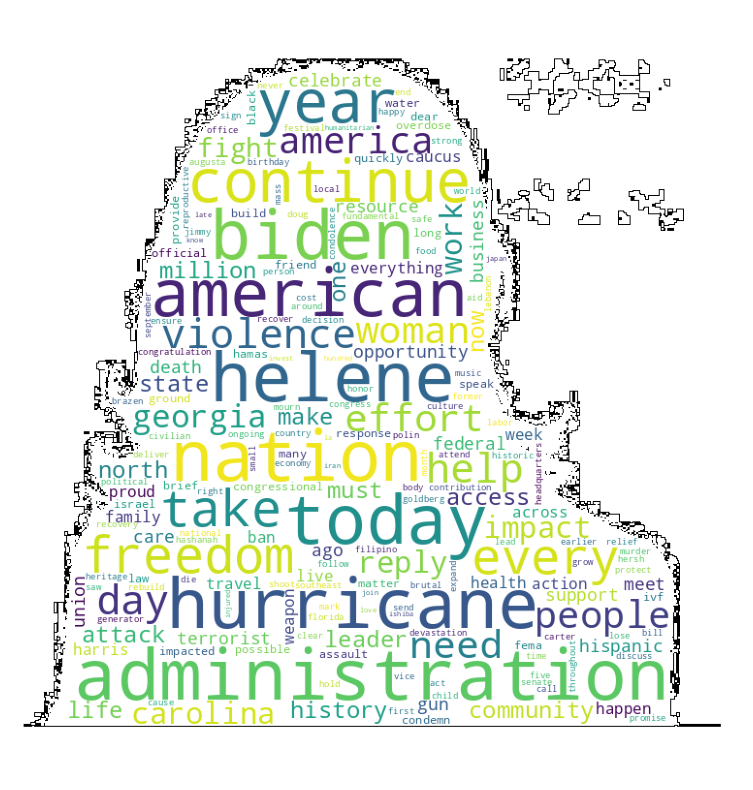

In [14]:
harris_wordcloud = WordCloud(relative_scaling = 0.2,
                     background_color='white',
                    width=800,
                    height=400,
                    mask=harris_mask,
                    contour_color='black',
                    contour_width=1
                     ).generate_from_frequencies(harris_TFIDF_frequencies)
plt.figure(figsize=(15,10))
plt.imshow(harris_wordcloud)
plt.axis("off")
plt.show()

PLOTLY

In [15]:
tt_df=pd.DataFrame(ttt.toarray(), columns=vector_tt.get_feature_names_out()).T
ht_df=pd.DataFrame(htt.toarray(), columns=vector_ht.get_feature_names_out()).T

In [16]:
tt_df.reset_index(inplace=True)
ht_df.reset_index(inplace=True)

In [17]:
tt_df.rename(columns={'index':'Word', 0:'Frequency'}, inplace=True)
ht_df.rename(columns={'index':'Word', 0:'Frequency'}, inplace=True)

tt_df.sort_values(by='Frequency', ascending=False, inplace=True)
ht_df.sort_values(by='Frequency', ascending=False, inplace=True)

In [18]:
tt_df.head()

,Word,Frequency
312,great,29
26,america,21
514,now,21
456,make,20
539,pennsylvania,20


In [19]:
import plotly.express as px

tt_df_fig = px.bar(tt_df[:20], x='Word',y='Frequency', color='Frequency', color_continuous_scale=px.colors.sequential.Cividis_r, title='Trump\'s Twitter by Term Frequency')
ht_df_fig = px.bar(ht_df[:20], x='Word',y='Frequency',color='Frequency', color_continuous_scale=["green", "purple", "red"], title='To Harris\'s Twitter by Term Frequency')

tt_df_fig.show()
ht_df_fig.show()

In [20]:
trump_plot=pd.DataFrame(trump_TFIDF_frequencies, index=['frequency']).T
harris_plot=pd.DataFrame(harris_TFIDF_frequencies, index=['frequency']).T

In [21]:
trump_plot.reset_index(inplace=True)
harris_plot.reset_index(inplace=True)

In [22]:
trump_plot.rename(columns={'index':'Word', 'frequency':'Frequency'}, inplace=True)
harris_plot.rename(columns={'index':'Word', 'frequency':'Frequency'}, inplace=True)

In [23]:
trump_plot.sort_values(by='Frequency', ascending=False, inplace=True)
harris_plot.sort_values(by='Frequency', ascending=False, inplace=True)

In [24]:
trump_plot_fig = px.bar(trump_plot[:20], x='Word',y='Frequency', color='Frequency', color_continuous_scale=px.colors.sequential.Cividis_r, title='Trump\'s Twitter by TF-IDF')
harris_plot_fig = px.bar(harris_plot[:20], x='Word',y='Frequency',color='Frequency', color_continuous_scale=["green", "purple", "red"], title='Harris\'s Twitter by TF-IDF')

trump_plot_fig.show()
harris_plot_fig.show()

감성분석

In [25]:
!pip install sentiment_lexicon

In [26]:
!pip install vaderSentiment

In [27]:
from sentiment_lexicon import Lexicon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [28]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<1000} {}".format(sentence, str(score)))

In [29]:
analyser = SentimentIntensityAnalyzer()

In [30]:
tt_text_df=pd.DataFrame(tt_text, columns=['sent_corpus'])
ht_text_df=pd.DataFrame(ht_text, columns=['sent_corpus'])

tt_df=pd.read_csv('to_trump.csv')
ht_df=pd.read_csv('to_harris.csv')
new_tt_df=pd.concat([tt_df[['date','text']],tt_text_df], axis=1)
new_ht_df=pd.concat([ht_df[['date','text']],ht_text_df], axis=1)
# new_tt_df=pd.read_csv('to_trump.csv')
# new_ht_df=pd.read_csv('to_harris.csv')

In [31]:
tt_df.head()

,Unnamed: 0,all_text,name,id,date,text
0,0,MFM\n@mexicanfrommars\n·\nSep 1\n@realDonaldTr...,MFM,@mexicanfrommars,Sep 1,is a disgraceful piece of awful. at the gun s...
1,1,Trapdashian Xay\n@xXxRaTedd\n·\nSep 1\nReplyin...,Trapdashian Xay,@xXxRaTedd,Sep 1,@realDonaldTrump Trump if you would've built t...
2,2,perico papi\n@pericopapiii\n·\nSep 1\n@realDon...,perico papi,@pericopapiii,Sep 1,you gotta let me light you up fr Lil Pump @li...
3,3,Check Your Voter Registration Rainbows & Sunsh...,Check Your Voter Registration Rainbows & Sunshine,@dthutc,Sep 1,doesn't respect the grave of the mother of th...
4,4,Painter Reality Orientation\n@arobbie\n·\nSep ...,Painter Reality Orientation,@arobbie,Sep 1,"@realDonaldTrump Comrade Trump, is it true you..."


In [32]:
  # 🤬 trump
new_tt_temp =[]
analyzer = SentimentIntensityAnalyzer()
for sentence in new_tt_df['text']:
    # NaN 값을 문자열로 변환하거나 float 값을 문자열로 변환
    if pd.isna(sentence):  # NaN 값 체크
        sentence = "NaN"  # 또는 적절한 문자열로 대체
    else:
        sentence = str(sentence)  # 다른 경우, 숫자도 문자열로 변환

    vs = analyzer.polarity_scores(sentence)
    new_tt_temp.append("{:-<1000} {}".format(sentence, str(vs)))

  # 🥶 harris
new_ht_temp =[]
analyzer = SentimentIntensityAnalyzer()
for sentence in new_ht_df['text']:
    if pd.isna(sentence):  # NaN 값 체크
        sentence = "NaN"  # 또는 적절한 문자열로 대체
    else:
        sentence = str(sentence)  # 다른 경우, 숫자도 문자열로 변환

    vs = analyzer.polarity_scores(sentence)
    new_ht_temp.append("{:-<1000} {}".format(sentence, str(vs)))

In [33]:
# 🤬 trump
df_to_trump_senti = pd.DataFrame(new_tt_temp)
temp_trump = []
for text in df_to_trump_senti[0]:
    senten = text.split("{")
    for p in senten:
        point = p.split(",")
    res = {"sentence" : senten[0], "neg": point[0][6:], "neu": point[1][7:], "pos": point[2][7:], "compound" : point[3][12:-2]}
    temp_trump.append(res)

# 🥶 harris
df_to_harris_senti = pd.DataFrame(new_ht_temp)
temp_harris = []
for text in df_to_harris_senti[0]:
    senten = text.split("{")
    for p in senten:
        point = p.split(",")
    res = {"sentence" : senten[0], "neg": point[0][6:], "neu": point[1][7:], "pos": point[2][7:], "compound" : point[3][12:-2]}
    temp_harris.append(res)

In [34]:
# 🤬 trump
df_temp_trump = pd.DataFrame(temp_trump)
df_temp_trump[["neg", "neu", "pos","compound"]] = df_temp_trump[["neg", "neu", "pos","compound"]].astype("float32")

# 🥶 harris
df_temp_harris = pd.DataFrame(temp_harris)
df_temp_harris[["neg", "neu", "pos","compound"]] = df_temp_harris[["neg", "neu", "pos","compound"]].astype("float32")

In [35]:
to_trump_senti=pd.concat([new_tt_df,df_temp_trump], axis=1)
to_harris_senti=pd.concat([new_ht_df,df_temp_harris], axis=1)

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [36]:
to_trump_senti['sentiment']=np.where(to_trump_senti['compound']>=0.05,1, np.where(to_trump_senti['compound']<=-0.05,-1,0))
to_harris_senti['sentiment']=np.where(to_harris_senti['compound']>=0.05,1, np.where(to_harris_senti['compound']<=-0.05,-1,0))

In [37]:
to_trump_senti_by_date=to_trump_senti.groupby('date')[['neg','neu','pos','compound','sentiment']].mean()
to_harris_senti_by_date=to_harris_senti.groupby('date')[['neg','neu','pos','compound','sentiment']].mean()

to_trump_senti_by_date.to_csv("trump_senti_point.csv", index=False)
to_harris_senti_by_date.to_csv("harris_senti_point.csv", index=False)

In [38]:
to_trump_senti_by_date.index = pd.to_datetime(to_trump_senti_by_date.index, format='%b %d')
to_trump_senti_by_date.index = to_trump_senti_by_date.index.map(lambda x: x.replace(year=2024))

to_harris_senti_by_date.index = pd.to_datetime(to_harris_senti_by_date.index, format='%b %d')
to_harris_senti_by_date.index = to_harris_senti_by_date.index.map(lambda x: x.replace(year=2024))

In [56]:
# 날짜를 기준으로 데이터프레임 정렬
to_trump_senti_by_date = to_trump_senti_by_date.sort_index()
to_harris_senti_by_date = to_harris_senti_by_date.sort_index()

# 그래프 그리기
trump_line_fig = px.line(to_trump_senti_by_date, x=to_trump_senti_by_date.index, y=to_trump_senti_by_date['sentiment'], title='Sentiment towards Trump')
harris_line_fig = px.line(to_harris_senti_by_date, x=to_harris_senti_by_date.index, y=to_harris_senti_by_date['sentiment'], title='Sentiment towards Harris')

# x축 설정 업데이트
trump_line_fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
harris_line_fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# 그래프 출력
trump_line_fig.show()
harris_line_fig.show()

In [40]:
trump_bar_stock_fig = px.bar(to_trump_senti_by_date, x=to_trump_senti_by_date.index, y="sentiment")
harris_bar_stock_fig = px.bar(to_harris_senti_by_date, x=to_harris_senti_by_date.index, y="sentiment")
trump_bar_stock_fig.show()
harris_bar_stock_fig.show()

In [58]:
import plotly.graph_objects as go

trump_harris_sentimen = go.Figure()
trump_harris_sentimen.add_trace(go.Bar(
    x=to_trump_senti_by_date.index,
    y=to_trump_senti_by_date.sentiment,
    name='trump',
    marker_color='indianred'
))
trump_harris_sentimen.add_trace(go.Bar(
    x=to_harris_senti_by_date.index,
    y=to_harris_senti_by_date.sentiment,
    name='harris',
    marker_color='darkblue'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
trump_harris_sentimen.update_layout(barmode='group', xaxis_tickangle=-45, width=2000, height=800)
trump_harris_sentimen.show()

- 09/10 1차 토론
- 09/15 트럼프 골프장 암살 미수 사건

In [59]:
to_trump_senti_by_date.columns.name='emotion'
to_harris_senti_by_date.columns.name='emotion'

In [60]:
trump_area_fig = px.area(to_trump_senti_by_date, facet_col="emotion", facet_col_wrap=2, title='Emotion towards Trump')
harris_area_fig = px.area(to_harris_senti_by_date, facet_col="emotion", facet_col_wrap=2, title='Emotion towards harris')
trump_area_fig.show()
harris_area_fig.show()

compound : 복잡
- ex) 이 영화는 정말 좋았지만, 마지막 결말은 실망스러웠다.
- 긍정, 부정 모두 판단

sentiment : 단순
- 하나의 감정으로 판단